# Qwen 3 4B Instruct 2507: 2D Activation Space Scan

Repeat the 2D grid exploration for Qwen to compare with Llama 3.2 3B.

**Pipeline:**
1. Load Qwen complexity vectors (layer 35)
2. Construct orthogonal perpendicular vector
3. Normalize V_perp to match ||V_complexity||
4. Run 201×201 grid scan over α,β ∈ [-1, +1]
5. Save results to data/qwen_2d_grid_results.csv

**Hypothesis:** Qwen showed smoother steering behavior without Llama's discontinuity. Will the 2D landscape be simpler?

In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import textstat
import pandas as pd
import numpy as np
from datetime import datetime
import os

## Configuration

In [13]:
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"
DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
STEERING_LAYER = 35  # Last layer

# Grid configuration (match Llama scan)
TEST_PROMPT = "Can you explain quantum mechanics please?"
ALPHA_MIN = -1.0
ALPHA_MAX = 1.0
ALPHA_STEP = 0.01
BETA_MIN = -1.0
BETA_MAX = 1.0
BETA_STEP = 0.01

# Generation parameters
MAX_NEW_TOKENS = 200
BATCH_SIZE = 1024  # Adjust based on your GPU

# Paths
VECTORS_DIR = "vectors/Qwen3-4B-Instruct-2507"
OUTPUT_CSV = "data/qwen_2d_grid_results.csv"
PERP_VECTOR_PATH = f"{VECTORS_DIR}/perpendicular_vector.pt"

print(f"Device: {DEVICE}")
print(f"Grid size: {int((ALPHA_MAX-ALPHA_MIN)/ALPHA_STEP + 1)} × {int((BETA_MAX-BETA_MIN)/BETA_STEP + 1)} = {int((ALPHA_MAX-ALPHA_MIN)/ALPHA_STEP + 1) * int((BETA_MAX-BETA_MIN)/BETA_STEP + 1)} points")
print(f"Batch size: {BATCH_SIZE}")

Device: cuda
Grid size: 201 × 201 = 40401 points
Batch size: 1024


## Step 1: Load Complexity Vectors and Construct Perpendicular

In [14]:
# Load complexity vectors
vectors = torch.load(f"{VECTORS_DIR}/complexity_vectors.pt")
v_complexity = vectors[STEERING_LAYER]

print(f"Loaded {len(vectors)} layers")
print(f"Using layer {STEERING_LAYER}")
print(f"V_complexity shape: {v_complexity.shape}")
print(f"V_complexity L2 norm: {torch.norm(v_complexity).item():.4f}")

# Construct perpendicular vector using Gram-Schmidt (in float32 for precision)
v_complexity_f32 = v_complexity.float()

torch.manual_seed(42)  # Reproducibility
v_random_f32 = torch.randn_like(v_complexity_f32)

# Gram-Schmidt orthogonalization
dot_product_f32 = torch.dot(v_random_f32, v_complexity_f32)
norm_squared_f32 = torch.dot(v_complexity_f32, v_complexity_f32)
projection_f32 = (dot_product_f32 / norm_squared_f32) * v_complexity_f32
v_perpendicular_f32 = v_random_f32 - projection_f32

# Verify orthogonality
dot_check = torch.dot(v_perpendicular_f32, v_complexity_f32).item()
print(f"\nOrthogonality check (should be ~0): {dot_check}")

# Normalize to match V_complexity magnitude
v_complexity_norm = torch.norm(v_complexity_f32).item()
v_perpendicular_norm = torch.norm(v_perpendicular_f32).item()
v_perpendicular_normalized = v_perpendicular_f32 * (v_complexity_norm / v_perpendicular_norm)

print(f"\nAfter normalization:")
print(f"  ||V_complexity|| = {torch.norm(v_complexity_f32).item():.4f}")
print(f"  ||V_perpendicular|| = {torch.norm(v_perpendicular_normalized).item():.4f}")

# Convert back to bfloat16 to match model
v_perpendicular = v_perpendicular_normalized.bfloat16()

# Save for future use
os.makedirs(VECTORS_DIR, exist_ok=True)
torch.save(v_perpendicular, PERP_VECTOR_PATH)
print(f"\n✓ Saved perpendicular vector to {PERP_VECTOR_PATH}")

Loaded 36 layers
Using layer 35
V_complexity shape: torch.Size([2560])
V_complexity L2 norm: 87.0000

Orthogonality check (should be ~0): -3.4332275390625e-05

After normalization:
  ||V_complexity|| = 87.0328
  ||V_perpendicular|| = 87.0328

✓ Saved perpendicular vector to vectors/Qwen3-4B-Instruct-2507/perpendicular_vector.pt


## Step 2: Load Model

In [15]:
print(f"Loading model: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() or torch.backends.mps.is_available() else torch.float32,
    device_map="auto",
)
model.eval()
print("✓ Model loaded")

Loading model: Qwen/Qwen3-4B-Instruct-2507


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

✓ Model loaded


## Step 3: Define Steering Functions

In [16]:
def generate_batch_with_steering(prompt, alpha_beta_pairs):
    """
    Generate text for multiple (α, β) pairs simultaneously.
    
    Args:
        prompt: The text prompt
        alpha_beta_pairs: List of (alpha, beta) tuples
    
    Returns:
        List of generated texts
    """
    batch_size = len(alpha_beta_pairs)
    
    # Format prompts (same for all)
    messages = [{"role": "user", "content": prompt}]
    formatted_prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    
    # Tokenize and create batch
    inputs = tokenizer([formatted_prompt] * batch_size, return_tensors="pt", padding=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Compute steering vectors for entire batch
    steering_vectors = torch.stack([
        (alpha * v_complexity + beta * v_perpendicular).to(model.device)
        for alpha, beta in alpha_beta_pairs
    ])  # Shape: [batch_size, hidden_dim]
    
    # Define batched steering hook
    def steering_hook(module, input, output):
        if isinstance(output, tuple):
            hidden_states = output[0]
        else:
            hidden_states = output
        
        # Apply different steering vector to each batch element
        steered = hidden_states + steering_vectors.unsqueeze(1)  # Add seq_len dimension
        
        if isinstance(output, tuple):
            return (steered,) + output[1:]
        else:
            return steered
    
    # Register hook
    hook_handle = model.model.layers[STEERING_LAYER].register_forward_hook(steering_hook)
    
    try:
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=MAX_NEW_TOKENS,
                do_sample=False,  # Greedy decoding for reproducibility
            )
        # Decode all outputs
        full_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    finally:
        hook_handle.remove()
    
    # Extract assistant responses
    generated_texts = []
    for full_text in full_texts:
        # Handle Qwen's chat format
        if "<|im_start|>assistant" in full_text:
            generated_text = full_text.split("<|im_start|>assistant", 1)[1]
            generated_text = generated_text.lstrip('\n')
        else:
            generated_text = full_text[len(prompt):].strip()
        
        # Clean up special tokens
        for token in ["<|im_end|>", "<|endoftext|>", "<|eot_id|>"]:
            if token in generated_text:
                generated_text = generated_text.split(token)[0]
        
        generated_texts.append(generated_text.strip())
    
    return generated_texts


def analyze_text(text):
    """Compute FK grade level and other metrics."""
    if not text or len(text.strip()) < 10:
        return {
            'flesch_kincaid_grade': 0.0,
            'word_count': 0,
            'sentence_count': 0,
        }
    
    try:
        return {
            'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
            'word_count': textstat.lexicon_count(text, removepunct=True),
            'sentence_count': textstat.sentence_count(text),
        }
    except:
        return {
            'flesch_kincaid_grade': 0.0,
            'word_count': 0,
            'sentence_count': 0,
        }

print("✓ Functions defined")

✓ Functions defined


## Step 4: Run 2D Grid Scan

In [17]:
start_time = datetime.now()
print(f"Starting batched 2D grid sweep at {start_time.strftime('%H:%M:%S')}")
print(f"Grid: α ∈ [{ALPHA_MIN}, {ALPHA_MAX}], β ∈ [{BETA_MIN}, {BETA_MAX}]")
print(f"Batch size: {BATCH_SIZE}\n")

alphas = np.arange(ALPHA_MIN, ALPHA_MAX + ALPHA_STEP/2, ALPHA_STEP)
betas = np.arange(BETA_MIN, BETA_MAX + BETA_STEP/2, BETA_STEP)

# Create all (alpha, beta) pairs
all_pairs = [(alpha, beta) for alpha in alphas for beta in betas]
total_points = len(all_pairs)

results = []

# Process in batches
for batch_start in range(0, total_points, BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, total_points)
    batch_pairs = all_pairs[batch_start:batch_end]
    
    print(f"[{batch_start+1}-{batch_end}/{total_points}] Processing batch of {len(batch_pairs)} points...", end=" ")
    
    # Generate for entire batch
    batch_texts = generate_batch_with_steering(TEST_PROMPT, batch_pairs)
    
    # Analyze each result
    for (alpha, beta), text in zip(batch_pairs, batch_texts):
        metrics = analyze_text(text)
        results.append({
            'alpha': alpha,
            'beta': beta,
            'generated_text': text,
            **metrics
        })
    
    # Show progress with grade levels
    gls = [analyze_text(t)['flesch_kincaid_grade'] for t in batch_texts]
    print(f"GL range: {min(gls):.1f}-{max(gls):.1f}")

df = pd.DataFrame(results)
end_time = datetime.now()
elapsed = (end_time - start_time).total_seconds() / 60

print(f"\n✓ Grid sweep complete in {elapsed:.1f} minutes")
print(f"Average time per point: {elapsed*60/total_points:.2f} seconds")

Starting batched 2D grid sweep at 23:30:50
Grid: α ∈ [-1.0, 1.0], β ∈ [-1.0, 1.0]
Batch size: 1024

[1-1024/40401] Processing batch of 1024 points... GL range: 8.3-12.3
[1025-2048/40401] Processing batch of 1024 points... GL range: 8.3-12.3
[2049-3072/40401] Processing batch of 1024 points... GL range: 8.3-12.9
[3073-4096/40401] Processing batch of 1024 points... GL range: 8.3-12.6
[4097-5120/40401] Processing batch of 1024 points... GL range: 8.5-12.4
[5121-6144/40401] Processing batch of 1024 points... GL range: 8.5-12.4
[6145-7168/40401] Processing batch of 1024 points... GL range: 8.5-12.9
[7169-8192/40401] Processing batch of 1024 points... GL range: 8.5-13.1
[8193-9216/40401] Processing batch of 1024 points... GL range: 8.5-13.1
[9217-10240/40401] Processing batch of 1024 points... GL range: 8.7-14.2
[10241-11264/40401] Processing batch of 1024 points... GL range: 8.7-14.2
[11265-12288/40401] Processing batch of 1024 points... GL range: 8.5-12.5
[12289-13312/40401] Processing bat

## Step 5: Save Results

In [18]:
os.makedirs('data', exist_ok=True)
df.to_csv(OUTPUT_CSV, index=False)
print(f"✓ Saved {len(df):,} points to {OUTPUT_CSV}")
print(f"  File size: {os.path.getsize(OUTPUT_CSV) / 1024 / 1024:.1f} MB")
print(f"\nGrade level range: {df['flesch_kincaid_grade'].min():.2f} to {df['flesch_kincaid_grade'].max():.2f}")

✓ Saved 40,401 points to data/qwen_2d_grid_results.csv
  File size: 40.7 MB

Grade level range: 8.27 to 16.70


## Quick Preview: Compare to Llama

How does Qwen's landscape differ?

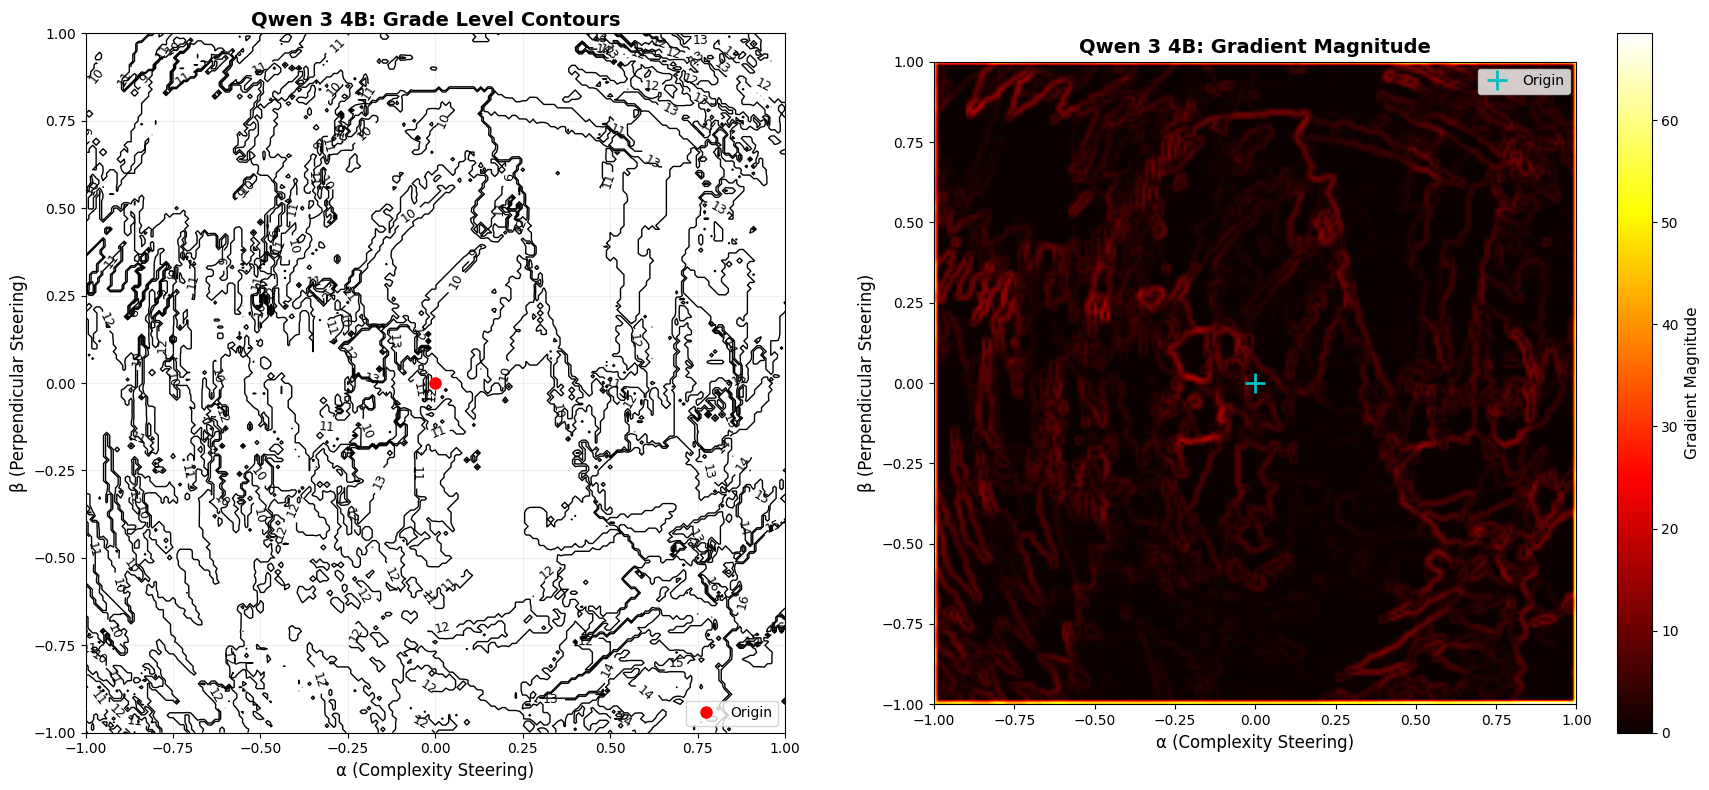


Quick comparison:
  Qwen gradient mean: 2.9914
  Qwen gradient max: 68.5065

Does Qwen show the sawtooth boundary that Llama had?


In [19]:
import matplotlib.pyplot as plt
from scipy.ndimage import sobel

# Reshape for visualization
pivot = df.pivot(index='beta', columns='alpha', values='flesch_kincaid_grade')
X = pivot.columns.values
Y = pivot.index.values
X_grid, Y_grid = np.meshgrid(X, Y)
Z = pivot.values

# Calculate gradients
grad_alpha = sobel(Z, axis=1, mode='constant')
grad_beta = sobel(Z, axis=0, mode='constant')
grad_magnitude = np.sqrt(grad_alpha**2 + grad_beta**2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Contour plot
levels = np.arange(8, 17, 1)
contours = ax1.contour(X_grid, Y_grid, Z, levels=levels, colors='black', linewidths=1)
ax1.clabel(contours, inline=True, fontsize=9)
ax1.plot(0, 0, 'ro', markersize=8, label='Origin')
ax1.set_xlabel('α (Complexity Steering)', fontsize=12)
ax1.set_ylabel('β (Perpendicular Steering)', fontsize=12)
ax1.set_title('Qwen 3 4B: Grade Level Contours', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.2)
ax1.set_aspect('equal')

# Gradient magnitude
im = ax2.imshow(grad_magnitude, cmap='hot', aspect='auto', origin='lower',
               extent=[-1, 1, -1, 1], interpolation='bilinear')
ax2.plot(0, 0, 'c+', markersize=15, markeredgewidth=2, label='Origin')
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label('Gradient Magnitude', fontsize=11)
ax2.set_xlabel('α (Complexity Steering)', fontsize=12)
ax2.set_ylabel('β (Perpendicular Steering)', fontsize=12)
ax2.set_title('Qwen 3 4B: Gradient Magnitude', fontsize=14, fontweight='bold')
ax2.legend()
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

print("\nQuick comparison:")
print(f"  Qwen gradient mean: {grad_magnitude.mean():.4f}")
print(f"  Qwen gradient max: {grad_magnitude.max():.4f}")
print(f"\nDoes Qwen show the sawtooth boundary that Llama had?")